In [53]:
! pip install --quiet --upgrade tensorflow-federated
#! pip install --quiet --upgrade aif360
! pip install tensorflow-privacy

#! pip install --upgrade scipy

In [54]:
import numpy as np
import pandas as pd
import requests
import collections
import tensorflow as tf
import tensorflow_federated as tff
import tensorflow_privacy as tfp
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
#from aif360.algorithms.preprocessing import Reweighing
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext tensorboard

np.random.seed(0)

tff.federated_computation(lambda: 'Hello, World!')()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


b'Hello, World!'

In [55]:
# list of column names
column_names = (
    ("age"),
    ("workclass"),
    ("fnlwgt"),
    ("education"),
    ("education-num"),
    ("marital-status"),
    ("occupation"),
    ("relationship"),
    ("race"),
    ("sex"),
    ("capital-gain"),
    ("capital-loss"),
    ("hours-per-week"),
    ("native-country"),
    ("salary")
)
categorical_features = ['workclass', 'marital-status',
                        'occupation', 'relationship', 'race', 'native-country']
continuous_features = ['age', 'fnlwgt', 'education-num', 'capital-gain',
                       'capital-loss', 'hours-per-week']

In [56]:
# Get the raw training data
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
data_response = requests.get(data_url)

# Process the raw text into lines
data_lines = data_response.text.splitlines()

# Create a Pandas DataFrame
df = pd.DataFrame([line.split(",") for line in data_lines])
df.columns = column_names

# Handle missing values (replace '?' with appropriate values - e.g., NaN)
df.replace('?', pd.NA, inplace=True)
df.dropna(inplace=True)

# Drop unnecessary column
df.drop(columns=['education'])

# Print the head of the DataFrame
print(df.head())
print(len(df))
print(df.dtypes)

  age          workclass   fnlwgt   education education-num  \
0  39          State-gov    77516   Bachelors            13   
1  50   Self-emp-not-inc    83311   Bachelors            13   
2  38            Private   215646     HS-grad             9   
3  53            Private   234721        11th             7   
4  28            Private   338409   Bachelors            13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

  capital-gain capital-loss hours-per-week  native-country  salary  
0         2174            0             40   United-States   <=50K  
1       

In [57]:
# Get the raw test data
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
data_response = requests.get(data_url)

# Process the raw text into lines
data_lines = data_response.text.splitlines()

# Create a Pandas DataFrame
df_test = pd.DataFrame([line.split(",") for line in data_lines])
df_test.columns = column_names

# Handle missing values (replace '?' with appropriate values - e.g., NaN)
df_test.replace('?', pd.NA, inplace=True)
df_test.dropna(inplace=True)
df_test['salary'] = df_test['salary'].str.rstrip('.')

# Drop unnecessary column
df_test.drop(columns=['education'])

# Print the head of the DataFrame
print(df_test.head())
print(len(df_test))
print(df_test.dtypes)

  age   workclass   fnlwgt      education education-num       marital-status  \
1  25     Private   226802           11th             7        Never-married   
2  38     Private    89814        HS-grad             9   Married-civ-spouse   
3  28   Local-gov   336951     Assoc-acdm            12   Married-civ-spouse   
4  44     Private   160323   Some-college            10   Married-civ-spouse   
5  18           ?   103497   Some-college            10        Never-married   

           occupation relationship    race      sex capital-gain capital-loss  \
1   Machine-op-inspct    Own-child   Black     Male            0            0   
2     Farming-fishing      Husband   White     Male            0            0   
3     Protective-serv      Husband   White     Male            0            0   
4   Machine-op-inspct      Husband   Black     Male         7688            0   
5                   ?    Own-child   White   Female            0            0   

  hours-per-week  native-country

In [58]:
# General data preprocessing
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoded_data = encoder.fit_transform(df[categorical_features])
sex_labels = list(df.sex.astype('category').unique())
sex_codes = list(df.sex.astype('category').cat.codes.unique())
sex_mapping = {sex_codes[i] : sex_labels[i] for i in range(len(sex_labels))}
salary_labels = list(df.salary.astype('category').unique())
salary_codes = list(df.salary.astype('category').cat.codes.unique())
mapping = {salary_codes[i] : salary_labels[i] for i in range(len(salary_labels))}

# Create new column names
new_column_names = encoder.get_feature_names_out(categorical_features)

# Convert encoded data to a new DataFrame
df_encoded = pd.DataFrame(encoded_data, columns=new_column_names)

# Combine with continuous and binary features
df_pre = pd.concat([df_encoded, df[continuous_features], df["sex"], df["salary"]], axis=1)

# Scale continuous features and encode binary features (may remove for privacy later)
df_pre[continuous_features] = df_pre[continuous_features].astype(int)
df_pre["sex"] = df_pre["sex"].replace(sex_labels, sex_codes)
scaler = StandardScaler()
df_pre[continuous_features] = scaler.fit_transform(df_pre[continuous_features])
df_pre["salary"] = df_pre["salary"].replace(salary_labels, salary_codes)
print(df_pre.dtypes)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


workclass_ ?               float64
workclass_ Federal-gov     float64
workclass_ Local-gov       float64
workclass_ Never-worked    float64
workclass_ Private         float64
                            ...   
capital-gain               float64
capital-loss               float64
hours-per-week             float64
sex                           int8
salary                        int8
Length: 92, dtype: object


In [59]:
# Test data preprocessing
# One-Hot Encoding
encoded_test_data = encoder.transform(df_test[categorical_features])
df_test_encoded = pd.DataFrame(encoded_data, columns=new_column_names)
# Label Encoding
df_test["sex"] = df_test["sex"].replace(sex_labels, sex_codes)
df_test["salary"] = df_test["salary"].replace(salary_labels, salary_codes)

# Scaling
df_test[continuous_features] = scaler.transform(df_test[continuous_features])

# Concatenate features in the same order as your training set
df_test_pre = pd.concat([df_test_encoded, df_test[continuous_features], df_test["sex"], df_test["salary"]], axis=1)

print(df_test_pre.dtypes)


workclass_ ?               float64
workclass_ Federal-gov     float64
workclass_ Local-gov       float64
workclass_ Never-worked    float64
workclass_ Private         float64
                            ...   
capital-gain               float64
capital-loss               float64
hours-per-week             float64
sex                        float64
salary                     float64
Length: 92, dtype: object


In [60]:
mapping

{0: ' <=50K', 1: ' >50K'}

In [61]:
sex_mapping

{1: ' Male', 0: ' Female'}

In [62]:
n_workers = 10
n_epochs = 10
shuffle_buffer_size = df_pre.shape[0]
batch_size = 100
prefetch_buffer_size = 25
input_shape = df_pre.shape[1] - 1
output_shape = len(salary_codes)
l2_norm_clip = 1.0
noise_multiplier = 1.5

n_samples = int(df_pre.shape[0] / n_workers)
assert n_samples > 0, "Each worker must be assigned at least one data point"

In [63]:
def preprocess(dataframe):

    """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
    def map_fn(dataset):
        return collections.OrderedDict(
            x=tf.cast(dataset[:,:-1], tf.float64),
            y=tf.cast(tf.reshape(dataset[:,-1], shape=(-1, 1)), tf.int64)
        )

    return tf.data.Dataset.from_tensor_slices(dataframe).repeat(n_epochs).shuffle(
        shuffle_buffer_size).batch(batch_size).map(map_fn).prefetch(prefetch_buffer_size)


client_data = [preprocess(df_pre) for _ in range(n_workers)]

In [64]:
def calculate_reweighing_weights(dataframe, sensitive_attr, target_attr):
    groups = dataframe.groupby([sensitive_attr, target_attr]).size().unstack(fill_value=0)
    marginal_target = groups.sum(axis=0)  # Count of each target class
    marginal_sensitive = groups.sum(axis=1)  # Count of each sensitive group
    total = groups.sum().sum()

    weights = total / (marginal_target * marginal_sensitive)

    # Map weights back to dataframe
    return dataframe.apply(lambda row: weights.loc[row[sensitive_attr], row[target_attr]], axis=1)

def RW_preprocess(dataframe):
    # Apply Reweighing for bias mitigation
    weights = calculate_reweighing_weights(dataframe, 'sex', 'salary')

    def map_fn(dataset):
        features = collections.OrderedDict(
            x=tf.cast(dataset[:, :-1], tf.float64),
            y=tf.cast(tf.reshape(dataset[:, -1], shape=(-1, 1)), tf.int64),
            sample_weights=weights
        )
        return features

    return tf.data.Dataset.from_tensor_slices(dataframe).repeat(n_epochs).shuffle(
        shuffle_buffer_size).batch(batch_size).map(map_fn).prefetch(prefetch_buffer_size)


RW_client_data = [preprocess(df_pre) for _ in range(n_workers)]

In [65]:
client_data

[<_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 91), dtype=tf.float64, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))])>,
 <_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 91), dtype=tf.float64, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))])>,
 <_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 91), dtype=tf.float64, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))])>,
 <_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 91), dtype=tf.float64, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))])>,
 <_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 91), dtype=tf.float64, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))])>,
 <_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 91), dtype=tf.float64, name=None)), ('y'

In [66]:
for i in range(n_workers):
    print(f"Worker {i+1} data contains {len(client_data[i])} training points")

Worker 1 data contains 3257 training points
Worker 2 data contains 3257 training points
Worker 3 data contains 3257 training points
Worker 4 data contains 3257 training points
Worker 5 data contains 3257 training points
Worker 6 data contains 3257 training points
Worker 7 data contains 3257 training points
Worker 8 data contains 3257 training points
Worker 9 data contains 3257 training points
Worker 10 data contains 3257 training points


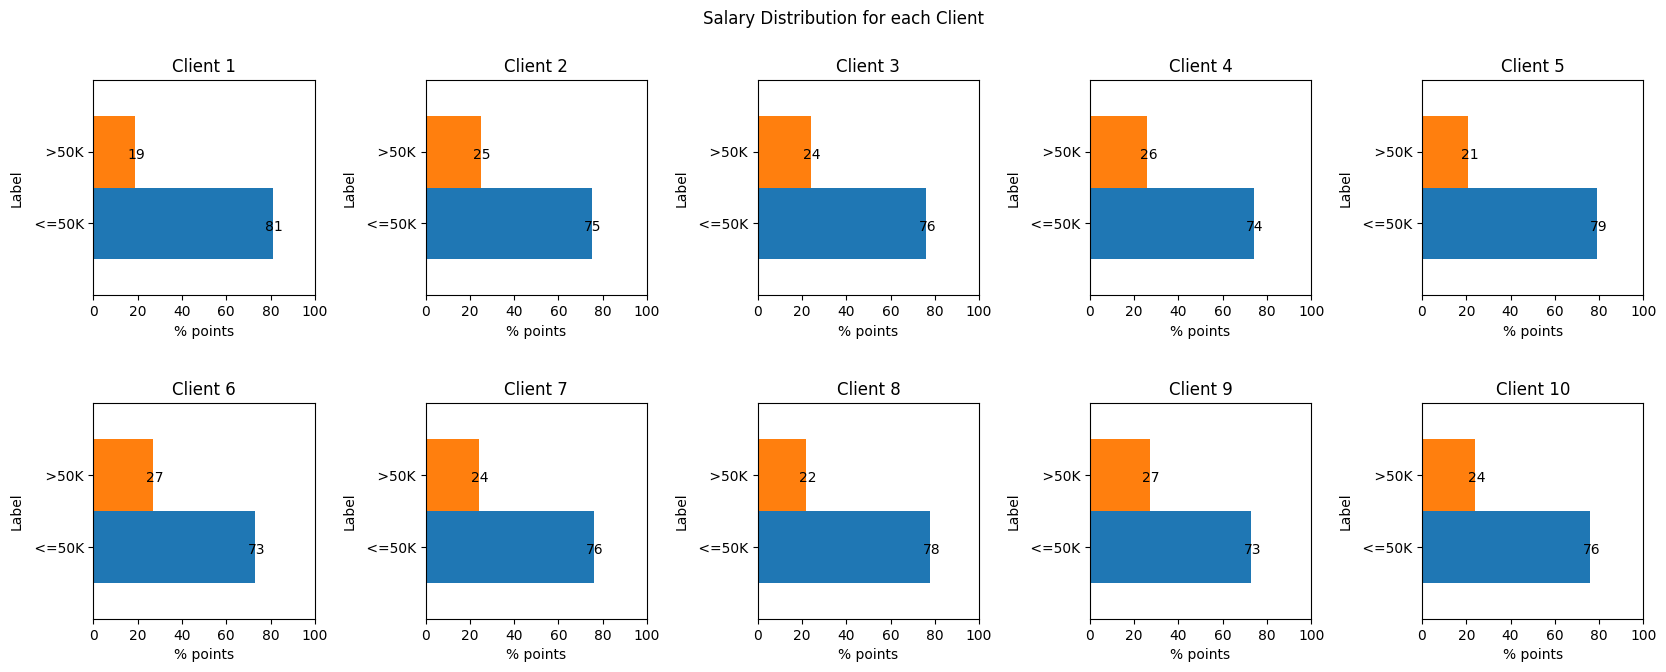

In [67]:
# Number of examples per layer for a sample of clients
fig = plt.figure(figsize=(20, 7))
fig.suptitle('Salary Distribution for each Client')
fig.tight_layout()

for i in range(n_workers):
    m = 0
    plot_data = collections.defaultdict(list)
    for label in list(client_data[i])[0]['y'].numpy()[:,0]:
        # Append counts individually per label to make plots
        # more colorful instead of one color per plot.
        plot_data[label].append(label)
        m = max(m, len(plot_data[label]))

    n_cols = n_workers if n_workers < 5 else 5
    #xlim = [0, m+(10-m%10)]
    xlim = [0, 100]
    ylim = [min(salary_codes)-1, max(salary_codes)+1]
    yticks = list(range(min(salary_codes), max(salary_codes)+1))
    yticks_labels = [mapping[k] for k in range(0, max(salary_codes)+1)]

    plt.subplot(int(n_workers / 10)+1, n_cols, i+1)
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.title('Client {}'.format(i+1))
    plt.xlabel('% points')
    plt.xlim(xlim)
    plt.ylabel('Label')
    plt.ylim(ylim)
    plt.yticks(yticks, labels=yticks_labels)

    # plot values on top of bars
    for key in plot_data:
        if len(plot_data[key]) > 0:
            plt.text(len(plot_data[key])+0.6, int(key)-0.1, str(len(plot_data[key])), ha='center')

    for j in range(min(salary_codes),max(salary_codes)+1):
        plt.hist(
            plot_data[j],
            density=False,
            bins=[k-0.5 for k in range(min(salary_codes),max(salary_codes)+2)],
            orientation='horizontal'
        )

In [42]:
def model_fn():
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_shape,)),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1, kernel_initializer='zeros', activation='sigmoid')
    ])
    return tff.learning.models.from_keras_model(model,
        input_spec=collections.OrderedDict(
            x=tf.TensorSpec(shape=[None, input_shape], dtype=tf.float64),
            y=tf.TensorSpec(shape=[None, 1], dtype=tf.int64)),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.BinaryAccuracy()])

trainer = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.01),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)

def DP_model_fn():
    dp_model = tfp.DPSequential(
        l2_norm_clip=l2_norm_clip,
        noise_multiplier=noise_multiplier
    )
    dp_model.add(tf.keras.layers.InputLayer(input_shape=(input_shape,)))
    dp_model.add(tf.keras.layers.Dense(10, activation='relu'))
    dp_model.add(tf.keras.layers.Dense(1, kernel_initializer='zeros', activation='sigmoid'))

    return tff.learning.models.from_keras_model(
        keras_model=dp_model,
        input_spec=collections.OrderedDict(
            x=tf.TensorSpec(shape=[None, input_shape], dtype=tf.float64),
            y=tf.TensorSpec(shape=[None, 1], dtype=tf.int64)),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.BinaryAccuracy()]
    )

DP_trainer = tff.learning.algorithms.build_weighted_fed_avg(
    DP_model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.01),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)

In [43]:
print(trainer.initialize.type_signature.formatted_representation())

( -> <
  global_model_weights=<
    trainable=<
      float32[91,10],
      float32[10],
      float32[10,1],
      float32[1]
    >,
    non_trainable=<>
  >,
  distributor=<>,
  client_work=<>,
  aggregator=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  finalizer=<
    int64,
    float32[91,10],
    float32[10],
    float32[10,1],
    float32[1]
  >
>@SERVER)


In [44]:
print(DP_trainer.initialize.type_signature.formatted_representation())

( -> <
  global_model_weights=<
    trainable=<
      float32[91,10],
      float32[10],
      float32[10,1],
      float32[1]
    >,
    non_trainable=<>
  >,
  distributor=<>,
  client_work=<>,
  aggregator=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  finalizer=<
    int64,
    float32[91,10],
    float32[10],
    float32[10,1],
    float32[1]
  >
>@SERVER)


In [45]:
def evaluate(NUM_ROUNDS = 20):
  train_state = trainer.initialize()
  for round_num in range(NUM_ROUNDS):
    result = trainer.next(train_state, client_data)
    train_state = result.state
    train_metrics = result.metrics
    print('Round {:2d}, binary_accuracy: {}, loss: {}'.format(
              round_num+1, train_metrics['client_work']['train']['binary_accuracy'], train_metrics['client_work']['train']['loss']))

In [46]:
def RW_evaluate(NUM_ROUNDS = 20):
  train_state = trainer.initialize()
  for round_num in range(NUM_ROUNDS):
    result = trainer.next(train_state, RW_client_data)
    train_state = result.state
    train_metrics = result.metrics
    print('Round {:2d}, binary_accuracy: {}, loss: {}'.format(
              round_num+1, train_metrics['client_work']['train']['binary_accuracy'], train_metrics['client_work']['train']['loss']))

In [47]:
def DP_evaluate(NUM_ROUNDS = 20):
  train_state = DP_trainer.initialize()
  for round_num in range(NUM_ROUNDS):
    result = DP_trainer.next(train_state, client_data)
    train_state = result.state
    train_metrics = result.metrics
    # Compute privacy spent for this round
    # Privacy Analysis
    n = 32561
    epochs = round_num+1
    delta = 1e-5

    epsilon = tfp.compute_dp_sgd_privacy(
        n=n,
        batch_size=batch_size,
        noise_multiplier=noise_multiplier,
        epochs=epochs,
        delta=delta
    )
    print('Round {:2d}, binary_accuracy: {}, loss: {}, epsilon: {}, delta: {}'.format(
              round_num+1, train_metrics['client_work']['train']['binary_accuracy'], train_metrics['client_work']['train']['loss'], epsilon[0], delta))

In [48]:
def RW_DP_evaluate(NUM_ROUNDS = 20):
  train_state = DP_trainer.initialize()
  for round_num in range(NUM_ROUNDS):
    result = DP_trainer.next(train_state, RW_client_data)
    train_state = result.state
    train_metrics = result.metrics
    # Compute privacy spent for this round
    # Privacy Analysis
    n = 32561
    epochs = round_num+1
    delta = 1e-5

    epsilon = tfp.compute_dp_sgd_privacy(
        n=n,
        batch_size=batch_size,
        noise_multiplier=noise_multiplier,
        epochs=epochs,
        delta=delta
    )
    print('Round {:2d}, binary_accuracy: {}, loss: {}, epsilon: {}, delta: {}'.format(
              round_num+1, train_metrics['client_work']['train']['binary_accuracy'], train_metrics['client_work']['train']['loss'], epsilon[0], delta))

In [49]:
evaluate()

Round  1, binary_accuracy: 0.7591904401779175, loss: 0.7157203555107117
Round  2, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356
Round  3, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356
Round  4, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356
Round  5, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356
Round  6, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356
Round  7, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356
Round  8, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356
Round  9, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356
Round 10, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356
Round 11, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356
Round 12, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356
Round 13, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356
Round 14, binary_accuracy: 0.7591904401779175, loss: 0.693133652

In [50]:
RW_evaluate()

Round  1, binary_accuracy: 0.7591904401779175, loss: 0.71571284532547
Round  2, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356
Round  3, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356
Round  4, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356
Round  5, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356
Round  6, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356
Round  7, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356
Round  8, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356
Round  9, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356
Round 10, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356
Round 11, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356
Round 12, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356
Round 13, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356
Round 14, binary_accuracy: 0.7591904401779175, loss: 0.69313365221

In [51]:
DP_evaluate()

Round  1, binary_accuracy: 0.7591904401779175, loss: 0.7104663848876953, epsilon: 0.3275598175608667, delta: 1e-05


Round  2, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356, epsilon: 0.35035622797107074, delta: 1e-05


Round  3, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356, epsilon: 0.3730827107419797, delta: 1e-05


Round  4, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356, epsilon: 0.3958791211521837, delta: 1e-05


Round  5, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356, epsilon: 0.41867553156238774, delta: 1e-05


Round  6, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356, epsilon: 0.4414020143332966, delta: 1e-05


Round  7, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356, epsilon: 0.46419842474350065, delta: 1e-05


Round  8, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356, epsilon: 0.4869249075144096, delta: 1e-05


Round  9, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356, epsilon: 0.5097213179246136, delta: 1e-05


Round 10, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356, epsilon: 0.5325177283348177, delta: 1e-05


Round 11, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356, epsilon: 0.5552442111057265, delta: 1e-05


Round 12, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356, epsilon: 0.5780406215159306, delta: 1e-05


Round 13, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356, epsilon: 0.6007671042868394, delta: 1e-05


Round 14, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356, epsilon: 0.6224918995849434, delta: 1e-05


Round 15, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356, epsilon: 0.6441345948662616, delta: 1e-05


Round 16, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356, epsilon: 0.6657109015117475, delta: 1e-05


Round 17, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356, epsilon: 0.6873535967930655, delta: 1e-05


Round 18, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356, epsilon: 0.7083657946896471, delta: 1e-05


Round 19, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356, epsilon: 0.7290585475047482, delta: 1e-05


Round 20, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356, epsilon: 0.749076361063136, delta: 1e-05


In [52]:
RW_DP_evaluate()

Round  1, binary_accuracy: 0.7591904401779175, loss: 0.7104731798171997, epsilon: 0.3275598175608667, delta: 1e-05


Round  2, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356, epsilon: 0.35035622797107074, delta: 1e-05


Round  3, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356, epsilon: 0.3730827107419797, delta: 1e-05


Round  4, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356, epsilon: 0.3958791211521837, delta: 1e-05


Round  5, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356, epsilon: 0.41867553156238774, delta: 1e-05


Round  6, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356, epsilon: 0.4414020143332966, delta: 1e-05


Round  7, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356, epsilon: 0.46419842474350065, delta: 1e-05


Round  8, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356, epsilon: 0.4869249075144096, delta: 1e-05


Round  9, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356, epsilon: 0.5097213179246136, delta: 1e-05


Round 10, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356, epsilon: 0.5325177283348177, delta: 1e-05


Round 11, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356, epsilon: 0.5552442111057265, delta: 1e-05


Round 12, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356, epsilon: 0.5780406215159306, delta: 1e-05


Round 13, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356, epsilon: 0.6007671042868394, delta: 1e-05


Round 14, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356, epsilon: 0.6224918995849434, delta: 1e-05


Round 15, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356, epsilon: 0.6441345948662616, delta: 1e-05


Round 16, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356, epsilon: 0.6657109015117475, delta: 1e-05


Round 17, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356, epsilon: 0.6873535967930655, delta: 1e-05


Round 18, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356, epsilon: 0.7083657946896471, delta: 1e-05


Round 19, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356, epsilon: 0.7290585475047482, delta: 1e-05


Round 20, binary_accuracy: 0.7591904401779175, loss: 0.6931336522102356, epsilon: 0.749076361063136, delta: 1e-05
